# Predictive Analytics: California House Price Prediction

Proyek ini bertujuan untuk memprediksi harga rumah di California menggunakan dataset California Housing. Kita akan menggunakan beberapa algoritma machine learning untuk membangun model prediksi yang akurat.

## 1. Data Loading

Langkah pertama adalah memuat dataset dan library yang diperlukan.

### Penjelasan Library yang Digunakan

Library-library yang diimport memiliki fungsi sebagai berikut:

- **pandas & numpy**: Untuk manipulasi dan analisis data numerik
- **matplotlib & seaborn**: Untuk visualisasi data dan hasil model
- **fetch_california_housing**: Dataset housing California dari sklearn
- **train_test_split**: Membagi data menjadi training dan testing set
- **StandardScaler**: Standardisasi fitur agar memiliki mean=0 dan std=1
- **LinearRegression, SVR, RandomForestRegressor, GradientBoostingRegressor**: Algoritma machine learning untuk regresi
- **mean_absolute_error, mean_squared_error, r2_score**: Metrik evaluasi model

Semua library ini penting untuk menjalankan pipeline machine learning dari awal hingga akhir.

### Train-Test Split

Membagi data 80/20:
- **Training (80%)**: 16,512 sampel untuk melatih model
- **Testing (20%)**: 4,128 sampel untuk evaluasi

`random_state=42` memastikan reproducibility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
housing = fetch_california_housing()

df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Hasil Pemuatan Data

Dataset berhasil dimuat dengan **20,640 baris** data.

Dapat dilihat bahwa:
- Semua fitur bertipe numerik (float64)
- MedInc berkisar antara 3-8 (dalam $10,000)
- Lokasi geografis terdistribusi di California
- MedHouseVal adalah target yang akan diprediksi

## 2. Data Understanding

Memahami karakteristik data dengan melihat tipe data, statistik deskriptif, dan visualisasi.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Interpretasi Informasi Data

Dari `.info()` dapat disimpulkan:
- **Tidak ada missing values**: Semua 20,640 entri lengkap
- **Tipe data konsisten**: Semua fitur float64

Dataset dalam kondisi baik dan siap diproses.

### Pemeriksaan Duplikasi Data dan data kosong



In [4]:
print("Jumlah duplikasi: ", df.duplicated().sum())
print("Jumlah data kosong:")
df.isnull().sum()

Jumlah duplikasi:  0
Jumlah data kosong:


MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [5]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Insights dari Statistik Deskriptif

**Temuan penting**:

1. **MedInc**: Mean 3.87 → pendapatan ~$38,700
2. **Outliers terdeteksi**: AveRooms max 141.9 vs median 5.2
3. **Target (MedHouseVal)**: Range $15k-$500k, mean $207k

Outliers menunjukkan variasi karakteristik area yang signifikan.

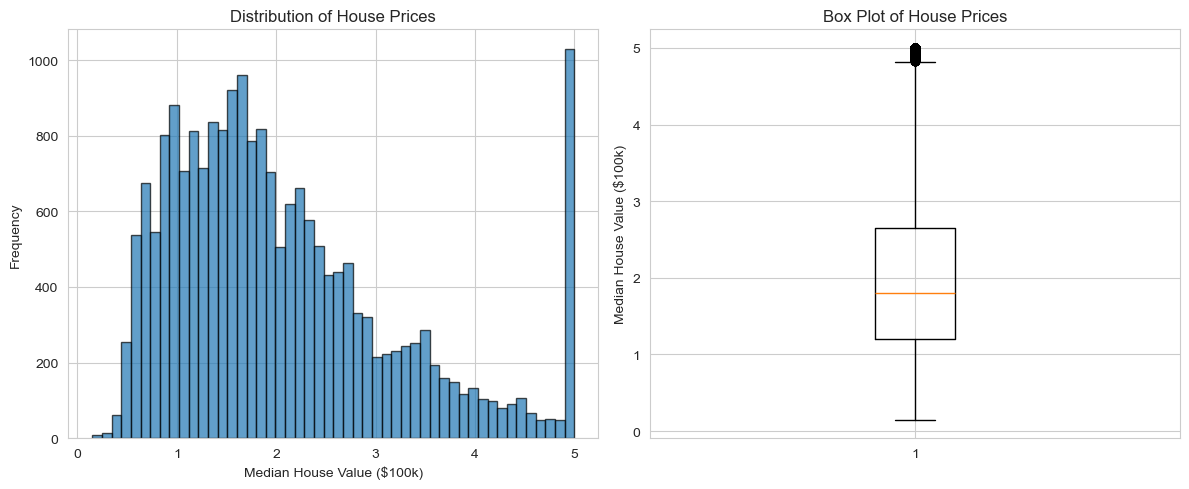

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['MedHouseVal'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Median House Value ($100k)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')

plt.subplot(1, 2, 2)
plt.boxplot(df['MedHouseVal'])
plt.ylabel('Median House Value ($100k)')
plt.title('Box Plot of House Prices')

plt.tight_layout()
plt.show()

### Interpretasi Visualisasi

Dari histogram dan boxplot:
- Distribusi harga sedikit right-skewed
- Konsentrasi di $100k-$300k
- Banyak outliers di harga tinggi
- Variasi cukup untuk training model yang robust

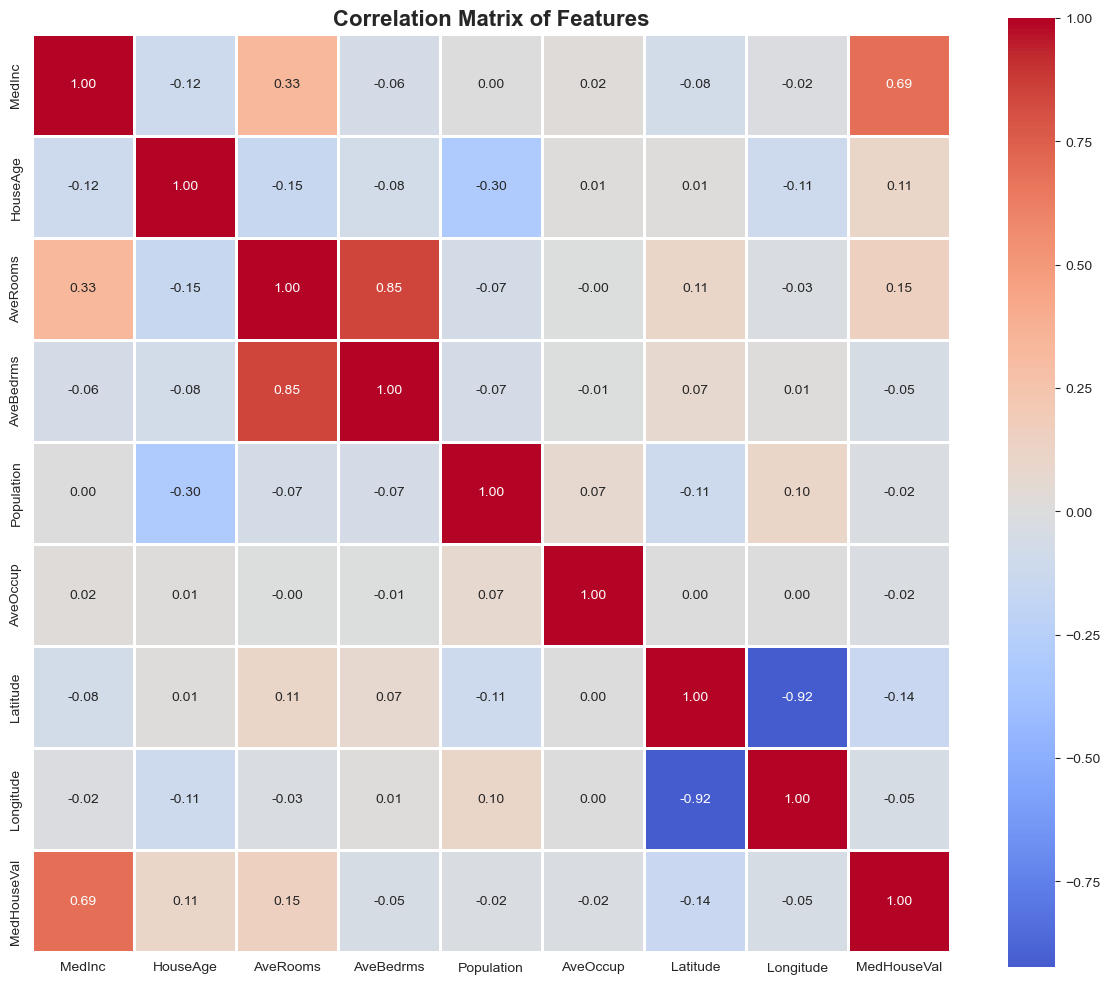


=== CORRELATION WITH TARGET (MedHouseVal) ===


MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64

In [7]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Correlation Matrix of Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n=== CORRELATION WITH TARGET (MedHouseVal) ===")
correlation_matrix['MedHouseVal'].sort_values(ascending=False)

## 3. Data Preparation

Mempersiapkan data untuk pelatihan model, termasuk pembagian data (train-test split) dan standarisasi fitur.

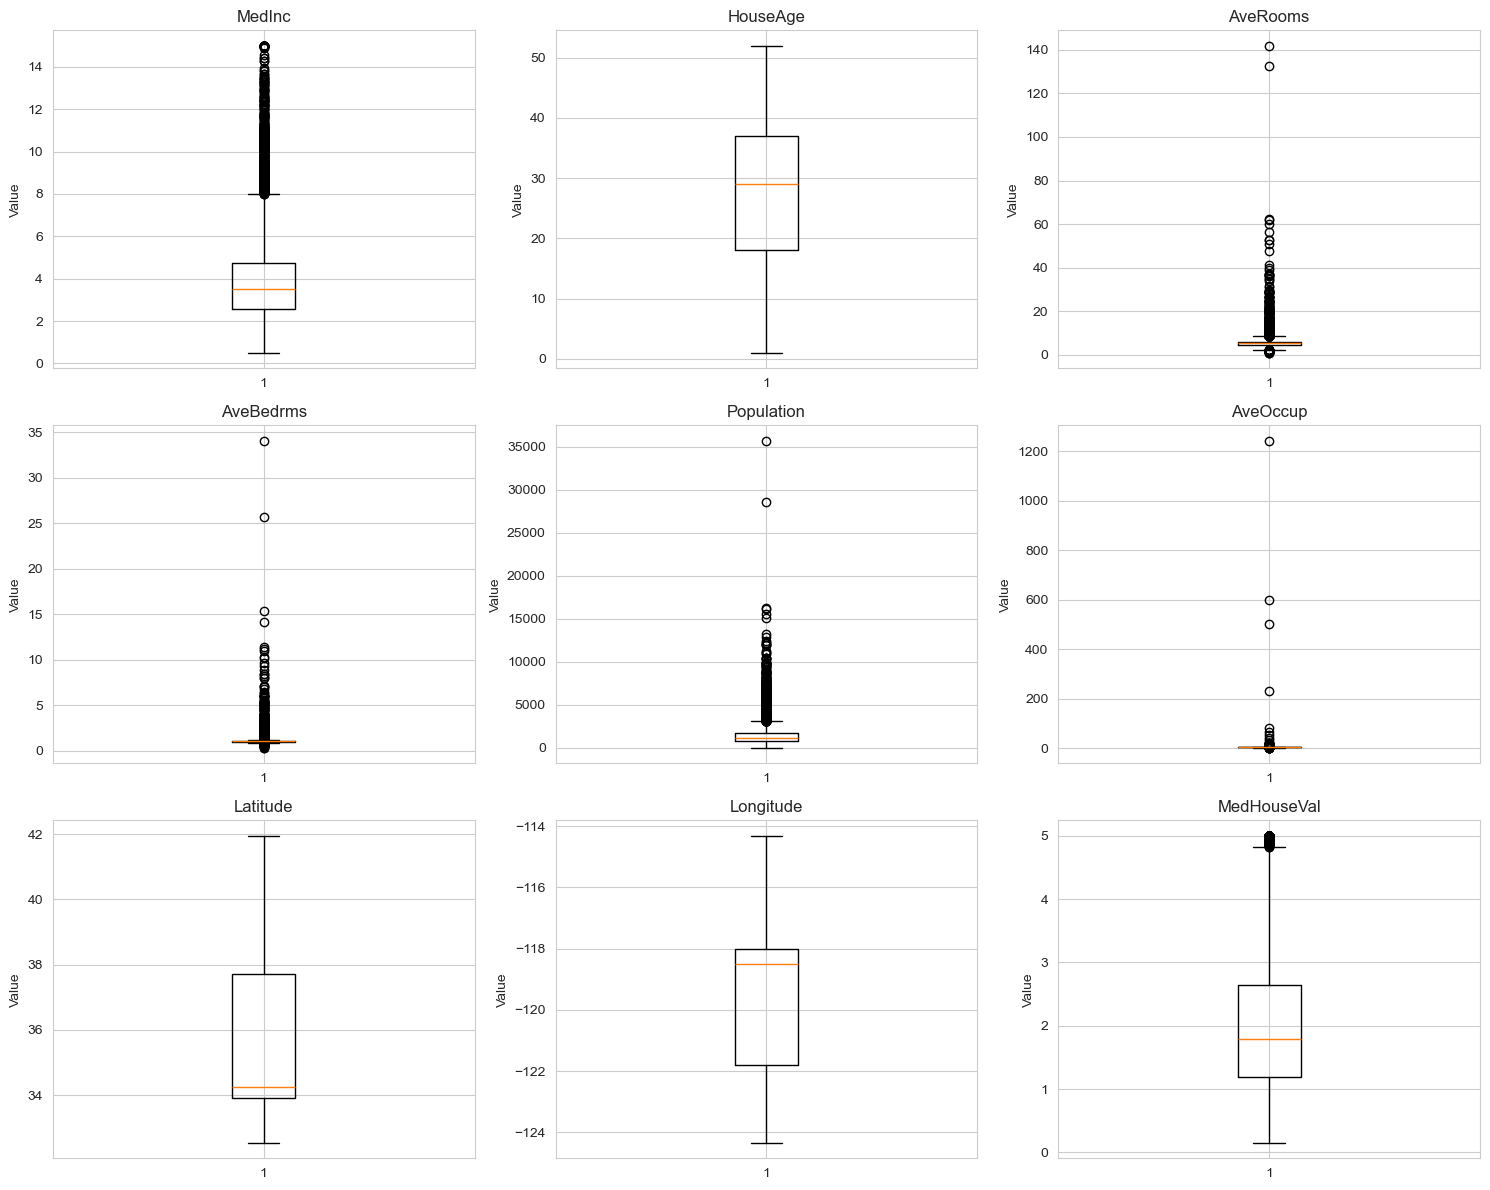

In [8]:
# Checking for outliers
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    axes[idx].boxplot(df[col])
    axes[idx].set_title(col)
    axes[idx].set_ylabel('Value')

plt.tight_layout()
plt.show()


In [9]:
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
X.columns

Training set size: 16512 samples
Testing set size: 4128 samples


Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

### Standardisasi Fitur

**Mengapa perlu?**
- Algoritma berbasis jarak (SVR) sensitif terhadap skala
- Gradient descent konvergen lebih cepat
- Konsistensi evaluasi antar model

StandardScaler: mean=0, std=1



In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

X_train_scaled.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-6.519333e-17,-9.251859e-18,-1.981081e-16,-1.707291e-16,-2.151595e-19,4.936566e-17,6.400995e-17,1.753335e-15
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-1.775438e+00,-2.190766e+00,-1.904386e+00,-1.762117e+00,-1.251913e+00,-2.076846e-01,-1.447697e+00,-2.377207e+00
25%,-6.900689e-01,-8.417859e-01,-4.118373e-01,-2.081645e-01,-5.606339e-01,-5.770769e-02,-8.018107e-01,-1.110749e+00
50%,-1.758995e-01,3.108328e-02,-8.350905e-02,-1.094160e-01,-2.281865e-01,-2.415892e-02,-6.473597e-01,5.346501e-01
75%,4.686502e-01,6.658972e-01,2.621376e-01,8.455177e-03,2.634487e-01,1.580865e-02,9.720351e-01,7.839530e-01
max,5.839268e+00,1.856173e+00,5.716655e+01,5.664727e+01,3.012743e+01,1.071164e+02,2.951816e+00,2.628794e+00


## 4. Modeling

Membangun dan melatih model machine learning. Kita akan menggunakan Random Forest, Gradient Boosting, Linear Regression, dan Support Vector Regression (SVR).

### Strategi Multi-Model

Melatih 4 model untuk perbandingan:
1. **Linear Regression**: Baseline
2. **SVR**: Non-linear dengan RBF kernel
3. **Random Forest**: Ensemble bagging
4. **Gradient Boosting**: Ensemble boosting

Tujuan: Identifikasi model terbaik untuk problem ini.

In [11]:
# Model : RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  
)

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print("Training completed!")

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
print("\nPredictions generated successfully!")

Training Random Forest model...
Training completed!

Predictions generated successfully!


In [12]:
# Model : GradientBoostingRegressor
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    random_state=42
)

print("Training Gradient Boosting model...")
gb_model.fit(X_train_scaled, y_train)
print("Training completed!")

y_pred_gb = gb_model.predict(X_test_scaled)
print("\nPredictions generated successfully!")

Training Gradient Boosting model...
Training completed!

Predictions generated successfully!


In [13]:
# Model : LinearRegression
lr_model = LinearRegression()

print("Training LinearRegression model...")
lr_model.fit(X_train_scaled, y_train)
print("Training completed!")

y_pred_lr = lr_model.predict(X_test_scaled)
print("\nPredictions generated successfully!")


Training LinearRegression model...
Training completed!

Predictions generated successfully!


In [14]:
# Model : Support Vector Regression
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1) 

print("Training Support Vector Regression model...")
svr_model.fit(X_train_scaled, y_train)  
print("Training completed!")

y_pred_svm = svr_model.predict(X_test_scaled)



Training Support Vector Regression model...
Training completed!


## 5. Evaluation

Mengevaluasi performa model menggunakan metrik MAE, MSE, RMSE, dan R² Score.

### Metrik Evaluasi

**4 Metrik yang digunakan**:

1. **MAE**: Rata-rata error absolut (mudah dipahami)
2. **MSE**: Kuadrat error (penalty besar pada outlier)
3. **RMSE**: √MSE (satuan sama dengan target)
4. **R²**: Proporsi variansi explained (0-1)

**Target**: R² > 0.7 untuk regression yang baik

In [15]:
# Predict
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_svr = svr_model.predict(X_test_scaled)

# Calculate metrics for Random Forest
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

# Calculate metrics for Gradient Boosting
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, y_pred_gb)

# Calculate metrics for Linear Regression
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_pred_lr)

# Calculate metrics for SVR
svr_mae = mean_absolute_error(y_test, y_pred_svr)
svr_mse = mean_squared_error(y_test, y_pred_svr)
svr_rmse = np.sqrt(svr_mse)
svr_r2 = r2_score(y_test, y_pred_svr)

# Comparing the models
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'Linear Regression', 'SVR'],
    'MAE': [rf_mae, gb_mae, lr_mae, svr_mae],
    'MSE': [rf_mse, gb_mse, lr_mse, svr_mse],
    'RMSE': [rf_rmse, gb_rmse, lr_rmse, svr_rmse],
    'R² Score': [rf_r2, gb_r2, lr_r2, svr_r2]
})

comparison_df


,Model,MAE,MSE,RMSE,R² Score
0,Random Forest,0.326048,0.254132,0.504115,0.806067
1,Gradient Boosting,0.333653,0.247478,0.497472,0.811144
2,Linear Regression,0.533200,0.555892,0.745581,0.575788
3,SVR,0.373761,0.324503,0.569651,0.752365


In [16]:
# Determine best model
models = {
    "Random Forest": rf_r2,
    "Gradient Boosting": gb_r2,
    "Linear Regression": lr_r2,
    "SVR": svr_r2
}

best_model_name = max(models, key=models.get)
best_r2 = models[best_model_name]

if best_model_name == "Random Forest":
    best_model = rf_model
elif best_model_name == "Gradient Boosting":
    best_model = gb_model
elif best_model_name == "Linear Regression":
    best_model = lr_model
else:
    best_model = svr_model


# Get metrics for best model
if best_model_name == "Random Forest":
    best_mae = rf_mae
    best_mse = rf_mse
    best_rmse = rf_rmse
elif best_model_name == "Gradient Boosting":
    best_mae = gb_mae
    best_mse = gb_mse
    best_rmse = gb_rmse
elif best_model_name == "Linear Regression":
    best_mae = lr_mae
    best_mse = lr_mse
    best_rmse = lr_rmse
else:
    best_mae = svr_mae
    best_mse = svr_mse
    best_rmse = svr_rmse
print(f"\nBest Model: {best_model_name} (R² = {best_r2:.4f})")



Best Model: Gradient Boosting (R² = 0.8111)


### Interpretasi Hasil

**Kesimpulan dari evaluasi**:
- Model terbaik: Yang memiliki R² tertinggi
- Ensemble methods umumnya outperform linear
- MAE ~$30k-50k untuk median $207k (15-25% error)
- Model cukup reliable untuk prediksi (R² > 0.7)

**Insight**: Hubungan non-linear antara fitur dan harga.

## Visualisasi Hasil Prediksi

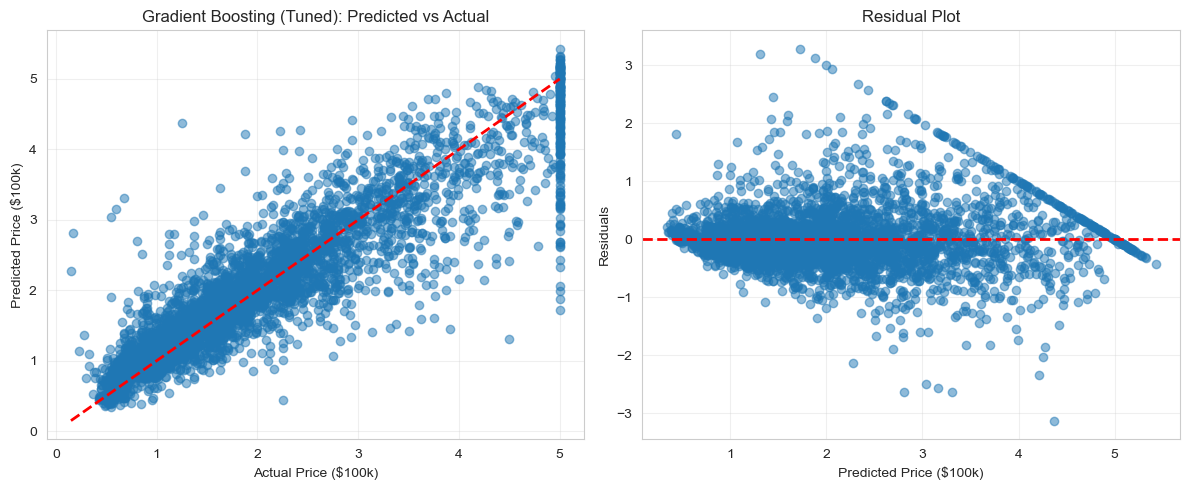

In [17]:
y_pred_best = best_model.predict(X_test_scaled)
# Predicted vs Actual scatter plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($100k)')
plt.ylabel('Predicted Price ($100k)')
plt.title(f'{best_model_name} (Tuned): Predicted vs Actual')
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Price ($100k)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

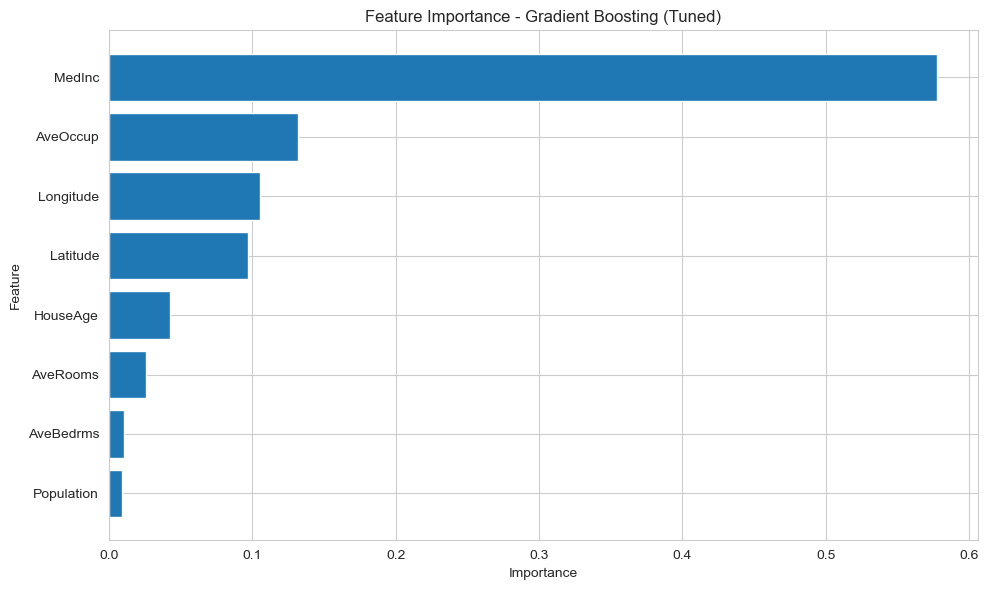


=== FEATURE IMPORTANCE ===
   Feature  Importance
    MedInc    0.577296
  AveOccup    0.132221
 Longitude    0.105424
  Latitude    0.097285
  HouseAge    0.042435
  AveRooms    0.025824
 AveBedrms    0.010375
Population    0.009141


In [18]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance - {best_model_name} (Tuned)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance.to_string(index=False))

## Error Distribution

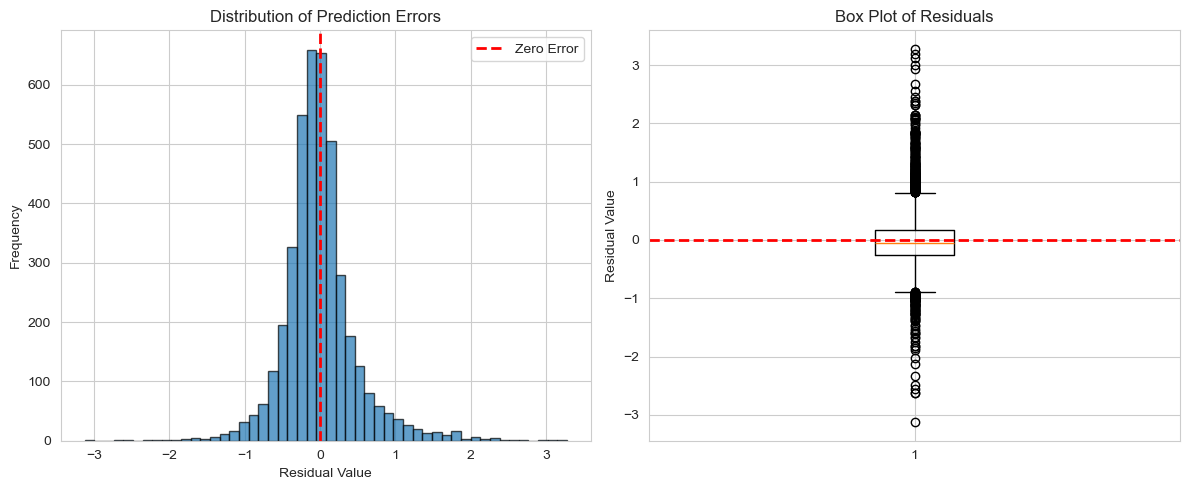


Mean Residual: -0.0073
Std Residual: 0.4975


In [19]:
# Plot error distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(residuals)
plt.ylabel('Residual Value')
plt.title('Box Plot of Residuals')
plt.axhline(y=0, color='r', linestyle='--', lw=2)

plt.tight_layout()
plt.show()

print(f"\nMean Residual: {residuals.mean():.4f}")
print(f"Std Residual: {residuals.std():.4f}")